## Zipcode Project
#### CS 522 - Data Mining
##### Author: Brandon Lasher <br> Email: bl7@hood.edu <br>
<br>

Data set link: [https://www.unitedstateszipcodes.org/zip-code-database/](https://www.unitedstateszipcodes.org/zip-code-database/) <br>
Map link and tutorial: [https://github.com/joncutrer/geopandas-tutorial](https://github.com/joncutrer/geopandas-tutorial) <br>


Steps:
1. Using the dataset of zip codes I pull the latitude, longitude and type information out of the csv.
2. Filter this data to the lower 48 states base on the latitude and longitude data.
3. Plot the initial boundary lines of the lower 48 states to verify this is correct.
4. Import the lat/long data to geopandas, to a format it will understand for plotting
5. Plot both the boundary of the lower 48 states and the zipcode coordinates

Next Steps:
1. Run a clustering on to the lat/long information to isolate the top 10 major cities in the lower 48 states 


In [2]:
import pandas as pd #csv handler
import numpy as np  

#Plotting libs
import seaborn as sns
from matplotlib import pyplot as plt
#Display plots inline for Jupyter Notebook
%matplotlib inline

#Map Library
import geopandas as gpd

***
### Reading in the Data
<a id="reading_in_data"></a>

In [3]:
#read Input data
df = pd.read_csv('zip_code_database.csv')
df.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [4]:
# ZIPCODE TYPES: PO Box, Unique, Military, and Standard.
# 
# Bounds of lower 48 via google search
#top = 49.3457868 # north lat
#left = -124.7844079 # west long
#right = -66.9513812 # east long
#bottom =  24.7433195 # south lat
#
df = df[['zip','latitude', 'longitude']][ ( (df['type'] == "STANDARD") | (df['type'] == "PO BOX") ) & ((df['latitude'] < 50) &  (df['latitude'] > 24.7)) & ((df['longitude'] < -66.9) &  (df['longitude'] > -124.6))  ]
df.head()


,zip,latitude,longitude
194,1001,42.06,-72.61
195,1002,42.37,-72.52
196,1003,42.39,-72.52
197,1004,42.37,-72.52
198,1005,42.42,-72.10


In [5]:
#Check the number of NA, just in case
df.isna().sum()

zip          0
latitude     0
longitude    0
dtype: int64

***
### Ploting Initial Data
<a id="plotting_initial_data"></a>

In [6]:
#Read the map data into geopandas
states = gpd.read_file('data/usa-states-census-2014.shp')
states.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


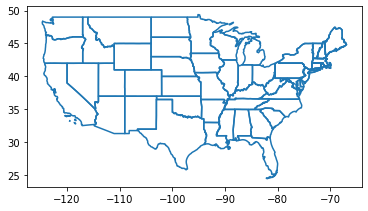

In [7]:
#Plot just the boundary of each state
states.boundary.plot()
plt.show()

In [8]:
#Convert the lat / long data to geopandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [9]:
print(gdf.head())

      zip  latitude  longitude                    geometry
194  1001     42.06     -72.61  POINT (-72.61000 42.06000)
195  1002     42.37     -72.52  POINT (-72.52000 42.37000)
196  1003     42.39     -72.52  POINT (-72.52000 42.39000)
197  1004     42.37     -72.52  POINT (-72.52000 42.37000)
198  1005     42.42     -72.10  POINT (-72.10000 42.42000)


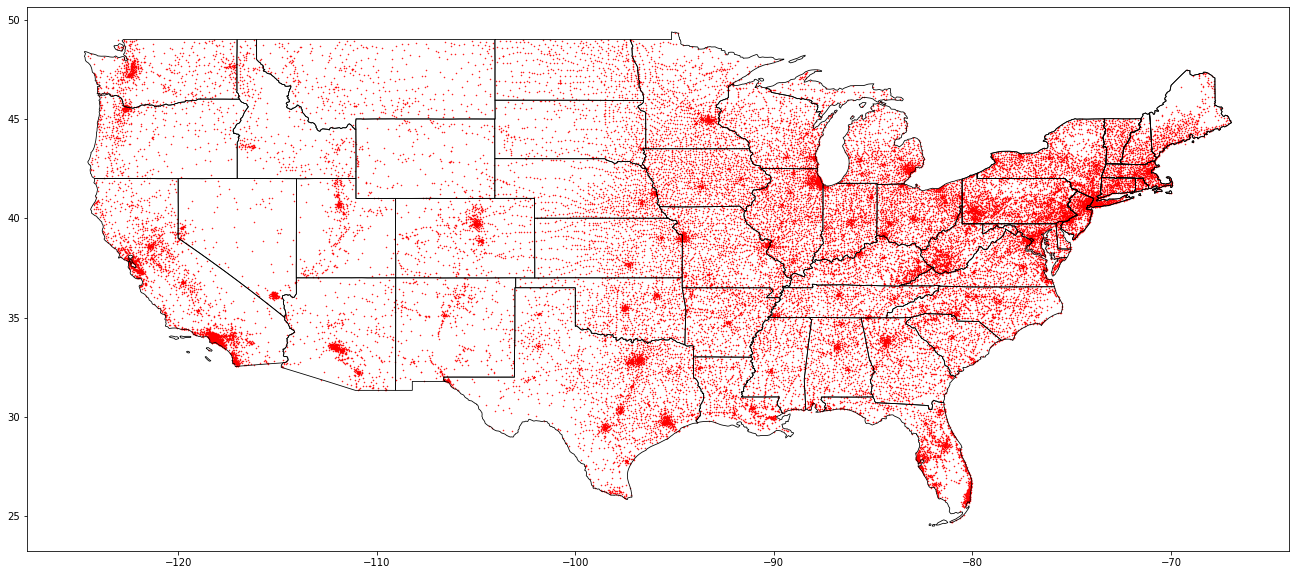

In [15]:
#
#Plot map and data on top one another
#

fig = plt.figure(1, figsize=(23,10)) 
ax = fig.add_subplot()

# Choose the bounding area that matches the lower US for the plot
#  -This is needed if the zipcode lat/long isn't filtered
#ax.set_xlim(-125, -67)
#ax.set_ylim(24, 50)

states.boundary.plot(ax=ax, color='black', linewidth=.8)
gdf.plot(ax=ax, color='red', marker='.', markersize=1)
plt.show()